In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [22]:
df_estimates = pd.read_csv("../../results/HG002/2024-03-19_hg002_str_length_calls.csv").rename(columns={"match": "our_match"}).drop("softmatch", axis=1)
df_gangstr = pd.read_csv("../../results/HG002/2024-03-19_hg002_str_length_calls_gangstr.csv").rename(columns={"match": "gangstr_match"}).drop(["haplo_region_len", "softmatch"], axis=1)

print(df_estimates.shape, df_gangstr.shape)

(1677861, 7) (1654569, 3)


In [23]:
df_estimates.head()

,str_id,haplo_region_len,estimated_region_len,our_match,copy_number,depth,period
0,chr1_588068,"[12, 12]","[12, 12]",True,2,22,3
1,chr1_589245,"[12, 12]","[12, 12]",True,2,9,2
2,chr1_590659,"[12, 12]","[12, 12]",True,2,60,4
3,chr1_590969,"[16, 16]","[16, 16]",True,2,42,4
4,chr1_591734,"[20, 20]","[20, 20]",True,2,11,1


In [24]:
df_gangstr.head()

,str_id,gangstr_region_len,gangstr_match
0,chr1_588068,"[12, 12]",True
1,chr1_589245,"[12, 12]",True
2,chr1_590659,"[12, 12]",True
3,chr1_590969,"[16, 16]",True
4,chr1_591734,"[20, 20]",True


In [25]:
df_str_calls = df_estimates.merge(df_gangstr, on="str_id", how="inner")
df_str_calls

,str_id,haplo_region_len,estimated_region_len,our_match,copy_number,depth,period,gangstr_region_len,gangstr_match
0,chr1_588068,"[12, 12]","[12, 12]",True,2,22,3,"[12, 12]",True
1,chr1_589245,"[12, 12]","[12, 12]",True,2,9,2,"[12, 12]",True
2,chr1_590659,"[12, 12]","[12, 12]",True,2,60,4,"[12, 12]",True
3,chr1_590969,"[16, 16]","[16, 16]",True,2,42,4,"[16, 16]",True
4,chr1_591734,"[20, 20]","[20, 20]",True,2,11,1,"[20, 20]",True
...,...,...,...,...,...,...,...,...,...
1653268,chrY_26627699,[12],[12],True,1,23,3,[12],True
1653269,chrY_26628607,[15],[15],True,1,31,5,[15],True
1653270,chrY_26632688,[19],[18],False,1,9,3,[18],False
1653271,chrY_26635262,[10],[10],True,1,33,1,[10],True


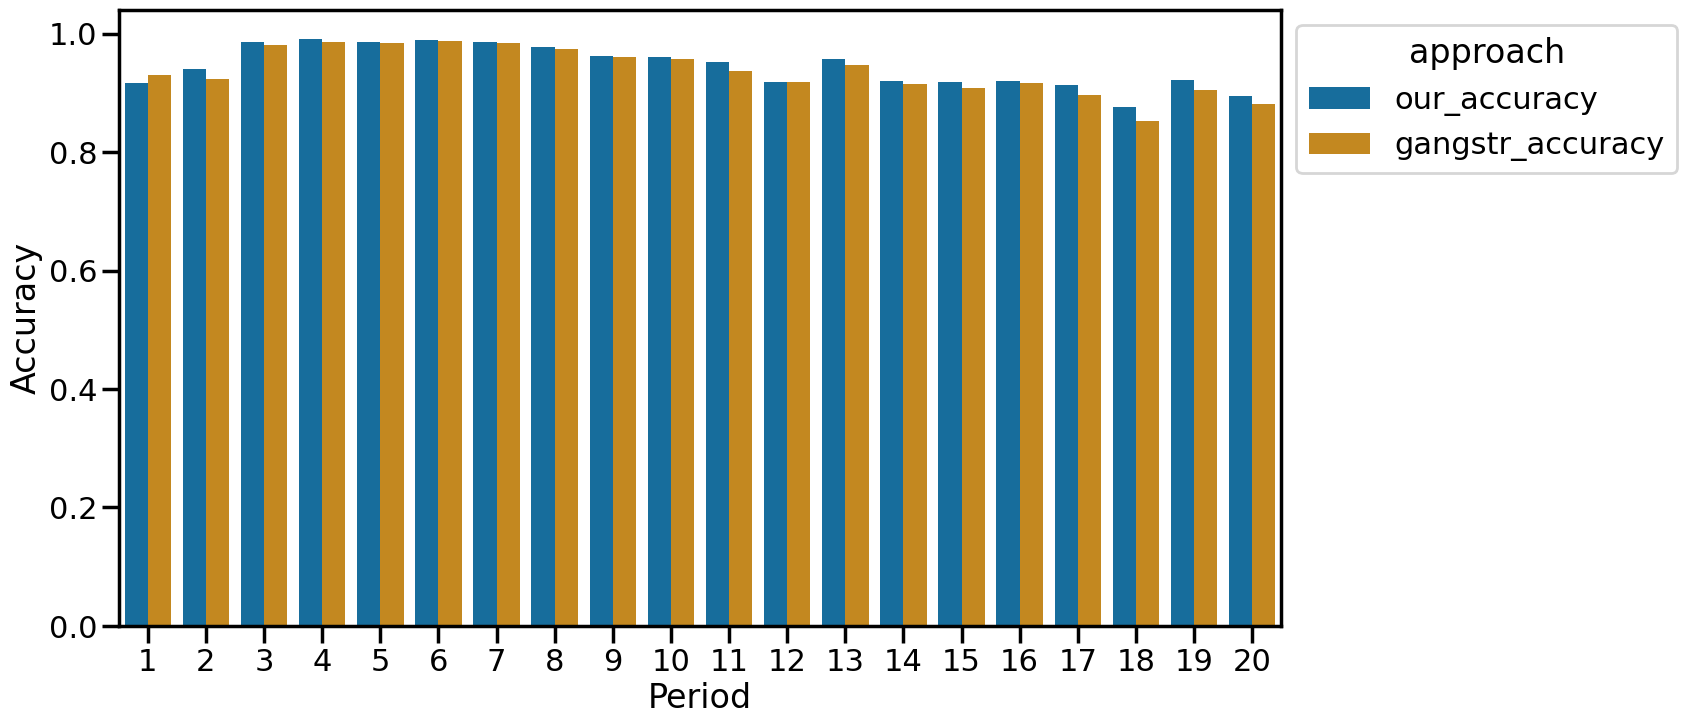

In [97]:
df_overview = df_str_calls[["period", "gangstr_match", "our_match"]].groupby("period", as_index=False).agg(
            our_accuracy = ("our_match", lambda x: x.sum() / len(x)), 
            gangstr_accuracy = ("gangstr_match", lambda x: x.sum() / len(x))).melt(id_vars="period", var_name="approach", value_name="accuracy")

fig = plt.figure(figsize=(15, 8))

ax = sns.barplot(
    data=df_overview,
    x="period",
    y="accuracy",
    hue="approach",
    palette="colorblind",
)

ax.set(
    xlabel="Period",
    ylabel="Accuracy",
)
ax.get_legend().set(bbox_to_anchor=(1,1))

plt.show()

In [96]:
print(
    df_str_calls["our_match"].sum() / df_str_calls.shape[0],
    df_str_calls["gangstr_match"].sum() / df_str_calls.shape[0],
)

print(df_str_calls.query("our_match and gangstr_match").shape)

print(df_str_calls.query("not our_match and not gangstr_match").shape)

print(df_str_calls.query("our_match and not gangstr_match").shape)

print(df_str_calls.query("not our_match and gangstr_match").shape)

0.9481966983069342 0.9517780789984474
(1536633, 9)
(48729, 9)
(30995, 9)
(36916, 9)


In [40]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 4).reshape(-1, 1), np.tile([1, 10, 10, 20, 20, 30, 30, 1000000], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

our_accuracy = []
gangstr_accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_str_calls
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_str_calls_filt = df_str_calls.loc[df_str_calls["str_id"].isin(selected_loci)]
    n.append(df_str_calls_filt.shape[0])
    our_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["our_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)
    gangstr_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["gangstr_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)    

df_plot["n"] = n
df_plot["our_accuracy"] = our_accuracy
df_plot["gangstr_accuracy"] = gangstr_accuracy
df_plot["depth"] = np.tile(["1-10", "10-20", "20-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,our_accuracy,gangstr_accuracy,depth
0,1,1,10,136398,65.890995,73.854455,1-10
1,1,10,20,172674,89.703719,93.154731,10-20
2,1,20,30,270665,98.270186,97.237545,20-30
3,1,30,1000000,272139,99.398837,98.258610,30-
4,2,1,10,3935,48.284625,44.675985,1-10
5,2,10,20,15020,80.812250,79.227696,10-20
6,2,20,30,44784,96.300018,94.247946,20-30
7,2,30,1000000,54522,99.211328,97.934779,30-
8,3,1,10,1535,66.514658,64.690554,1-10
9,3,10,20,6427,87.163529,85.171931,10-20


In [42]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["our_accuracy"], weights=data["n"]), np.average(data["gangstr_accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["our_accuracy"], weights=data["n"]), np.average(data["gangstr_accuracy"], weights=data["n"]), data["n"].sum())

1-10 65.60001648396934 72.9161515426248 145596
10-20 88.73944915940152 91.20643803621395 216215
20-30 98.52950829202791 97.57774889680303 533223
30- 99.63628146510372 98.97054664676679 739033

1 91.7099437007264 92.99217256971671 851876
2 94.07750653216192 92.39055986335309 118261
3 98.68754985135233 98.09876006090929 137910
4 99.07151211311758 98.60308040214534 334307
5 98.67290384908729 98.36464636192606 157336
6 99.02842016464497 98.81315996160224 34377


[None, None]

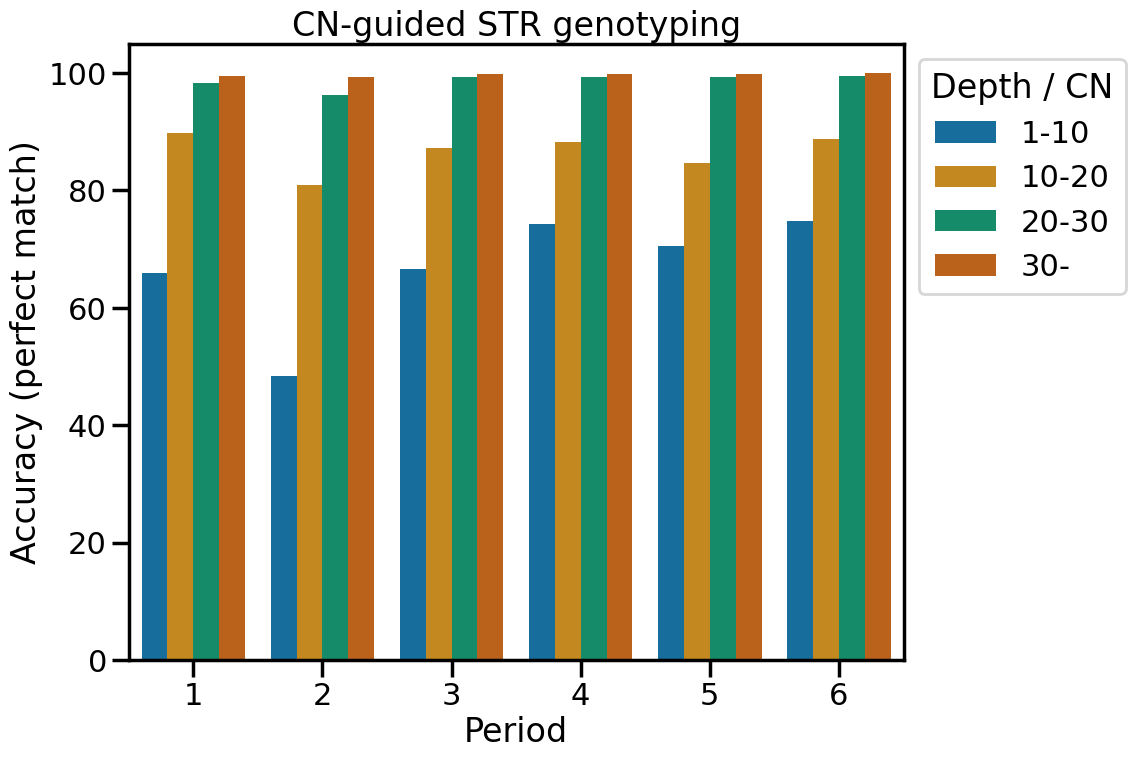

In [43]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="our_accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    title="CN-guided STR genotyping",
    xlabel="Period",
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

[None, None]

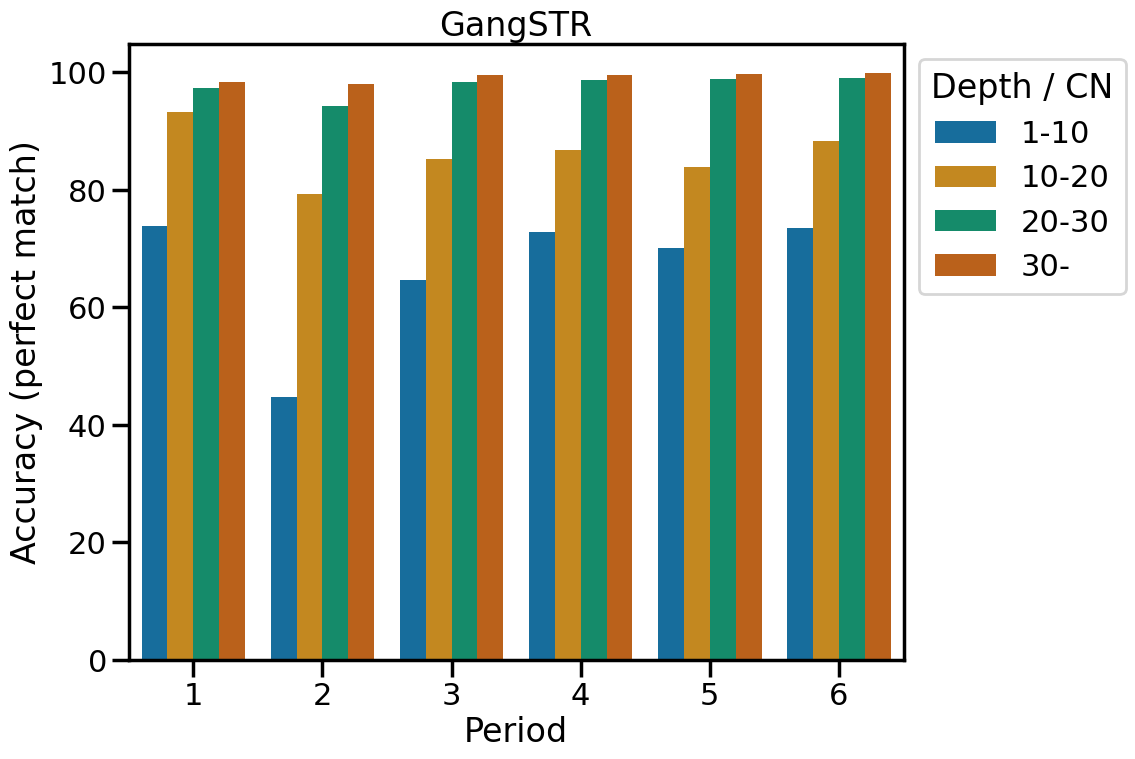

In [46]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="gangstr_accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    title="GangSTR",
    xlabel="Period",
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

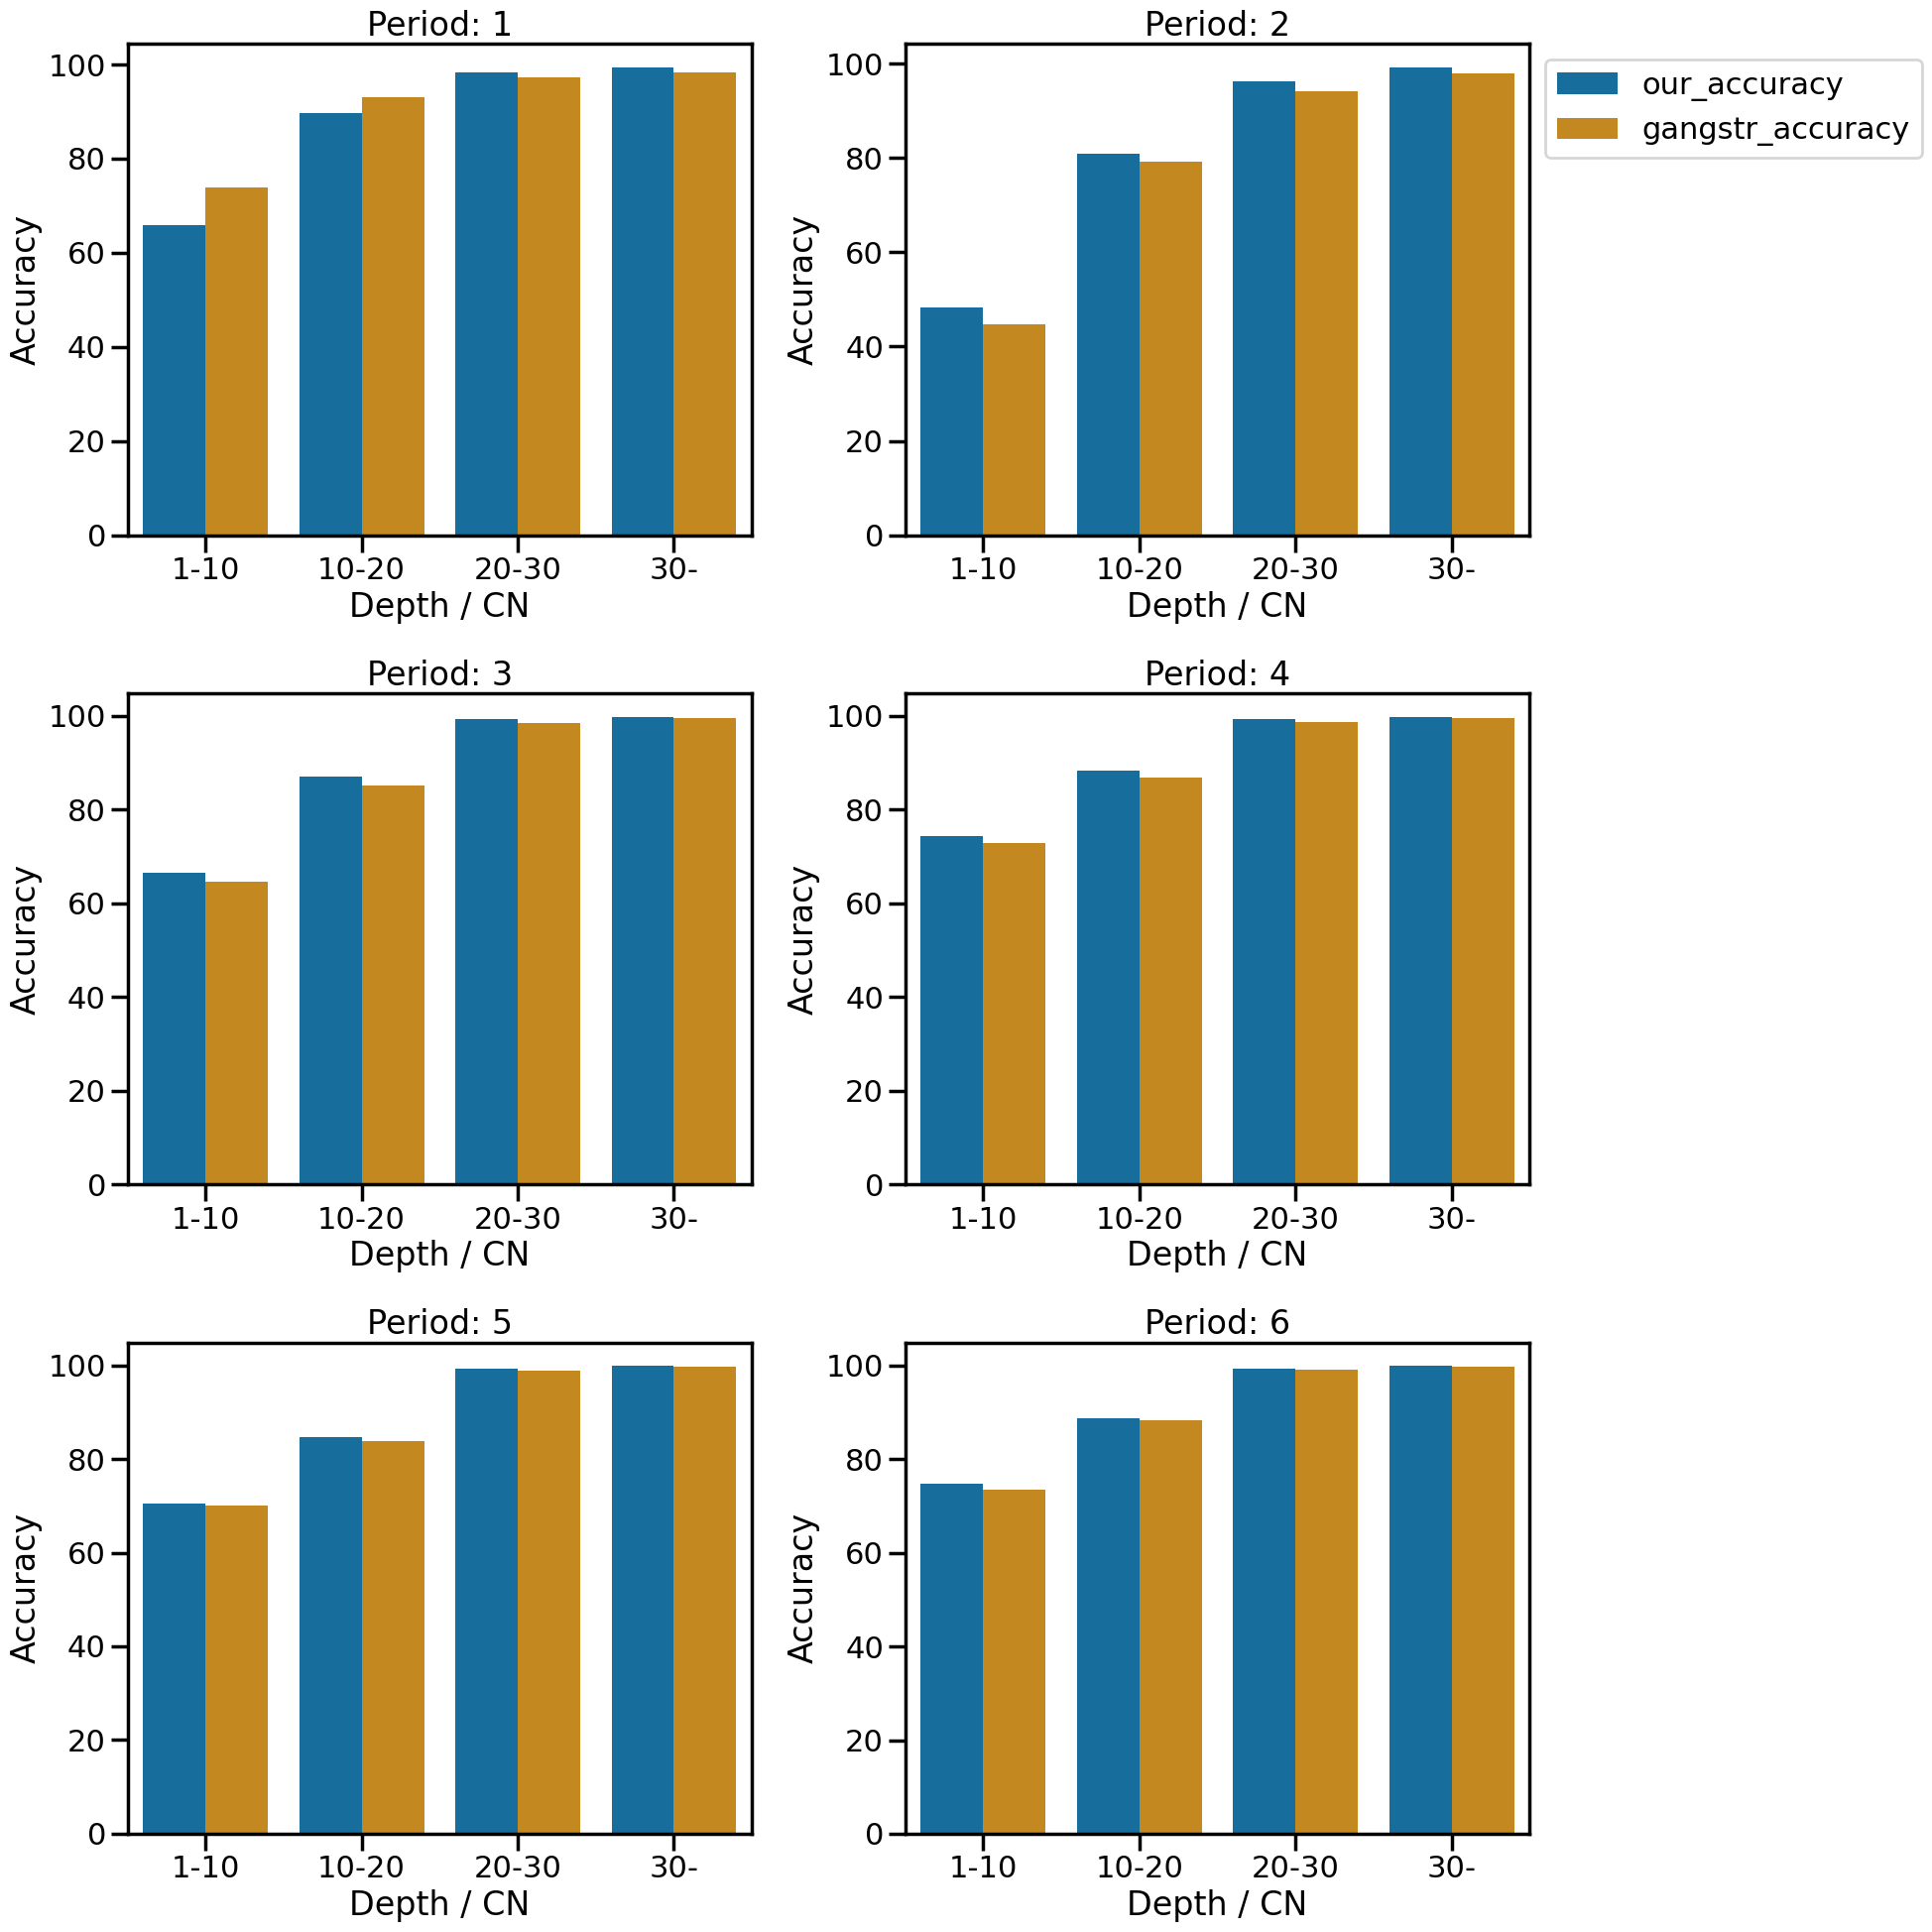

In [94]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot
                  .query(f"period == {period}")[["our_accuracy", "gangstr_accuracy", "depth"]]
                  .melt(id_vars="depth",var_name="approach", value_name="accuracy"))
    
    ax = sns.barplot(
        data=df_subplot,
        x="depth",
        y="accuracy",
        hue="approach",
        palette="colorblind",
        ax = ax,
        legend = period == 2
    )
    if period == 2:
        ax.get_legend().set(bbox_to_anchor = (1,1), title="")
    ax.set(
        title = f"Period: {period}",
        xlabel = "Depth / CN",
        ylabel = "Accuracy"
    )

plt.tight_layout()

In [48]:
from scipy import ndimage

max_period = 6
max_depth = 200
min_obs = 15

df_plot_cn = (
    df_str_calls
        .query(f"depth <= {max_depth} and period <= {max_period}")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["our_match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("our_match", lambda x: x.sum() / len(x)), 
            n_obs=("our_match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_cn.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_cn = df_plot_cn.assign(smooth = np.concatenate(smooth))

df_plot_cn

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.369422,2734,0.463026
1,1,1.5,0.422811,5059,0.473189
2,1,2.0,0.482301,6554,0.491933
3,1,2.5,0.506648,7220,0.516626
4,1,3.0,0.586115,8239,0.544375
...,...,...,...,...,...
963,6,48.0,1.000000,36,0.999853
964,6,48.5,1.000000,33,0.999929
965,6,49.0,1.000000,41,0.999969
966,6,49.5,1.000000,22,0.999988


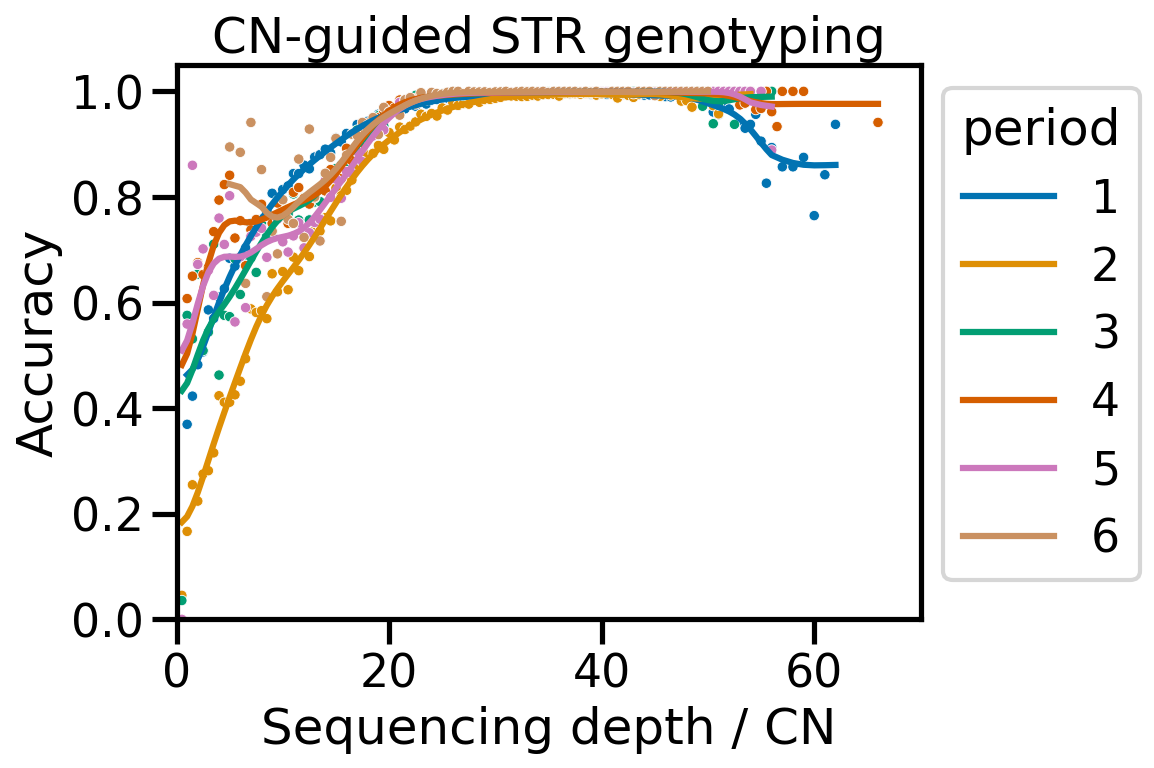

In [92]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_cn,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

ax = sns.scatterplot(
    df_plot_cn,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title = "CN-guided STR genotyping",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 70)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

In [37]:
from scipy import ndimage

max_period = 6
max_depth = 200
min_obs = 15

df_plot_cn = (
    df_str_calls
        .query(f"depth <= {max_depth} and period <= {max_period}")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["gangstr_match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("gangstr_match", lambda x: x.sum() / len(x)), 
            n_obs=("gangstr_match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_cn.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_cn = df_plot_cn.assign(smooth = np.concatenate(smooth))

df_plot_cn

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.451719,2734,0.509631
1,1,1.5,0.449496,5059,0.520370
2,1,2.0,0.512817,6554,0.540728
3,1,2.5,0.531717,7220,0.568667
4,1,3.0,0.611846,8239,0.601599
...,...,...,...,...,...
963,6,48.0,1.000000,36,0.995925
964,6,48.5,0.969697,33,0.995634
965,6,49.0,1.000000,41,0.995612
966,6,49.5,1.000000,22,0.995756


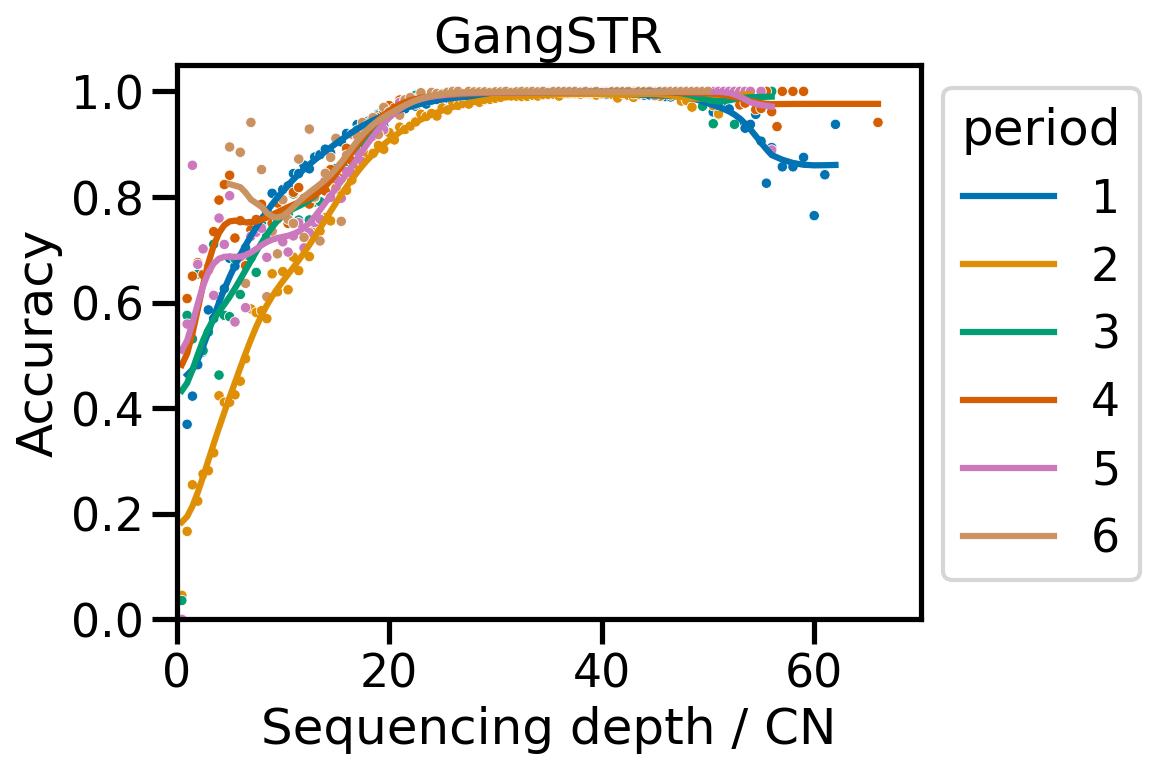

In [93]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_cn,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

ax = sns.scatterplot(
    df_plot_cn,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title = "GangSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 70)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()